# Búsqueda de Celdas Primitivas en un Intervalo Angular
En este ejemplo se utilizará Nookiin para explorar un sistema bicapa con un ángulo de rotación relativa entre capas variable dentro de un intervalo dado. El objetivo es encontrar celdas primitivas (PC) conmensurables para distintos valores de ángulo, siempre que la deformación requerida para lograr dicha conmensurabilidad en ambas capas sea menor que un valor umbral especificado, $\varepsilon$.

Este procedimiento es útil para analizar cómo varía la compatibilidad estructural entre capas en función del ángulo de rotación, lo cual es fundamental en el estudio de fenómenos como el moiré, la ingeniería de bandas y la modulación de propiedades electrónicas en sistemas bidimensionales apilados.

Durante el procedimiento se:

- Generará el sistema para distintos ángulos dentro del intervalo especificado.

- Buscarán soluciones conmensurables con deformaciones dentro del límite tolerado.

- Guardarán en archivos POSCAR aquellas configuraciones que cumplan los criterios establecidos.

- Guardará en un txt la información sobre las soluciones encontradas.

Este ejemplo resalta una de las principales funcionalidades de Nookiin: automatizar la búsqueda de superceldas eficientes para el estudio de heteroestructuras con rotaciones inter-capa, acelerando así el diseño y caracterización de materiales no convencionales.

### Carga de System y creación de Redes

La carga de las funciones requeridas se efectúa al importar nookiin y de este todas las funciones de nookiin.system, para esto es necesario ya haber instalado nookiin mediante el comando `pip install .` desde consola.

In [1]:
import sys
import os
import io

import nookiin
from nookiin.system import *

Load System
Nookiin Ready-to-work


In [2]:
VASP_Files = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'VASP_Files'))
G=importLattice(VASP_Files+'/01-graphene')
WS2=importLattice(VASP_Files+'/02-ws2')
G.name='G'
WS2.name='WS2'
G.inAngle=119 #Con esto evitamos que el programa regrese solamente redes hexagonales

File 'C:\SS\Nook’iin\Nook-iin\VASP_Files/01-graphene.vasp' will be read
--Lattice created successfully
File 'C:\SS\Nook’iin\Nook-iin\VASP_Files/02-ws2.vasp' will be read
--Lattice created successfully


### Función que efectúa la busqueda de Sistemas rotados que cumplen los requisitos.

In [3]:
def exploreSystems(L1,L2,tetas):
    ts=tetas.copy()
    Systems=[]
    orig = len(ts)
    i = 0
    errs = 0
    ep = 0.01
    m = 15
    pathS = os.path.join(os.getcwd(), 'VASP_Files/Sistemas-explorados')
    pathT = os.path.join(os.getcwd(), 'VASP_Files/Sistemas-explorados/Tablas')
    if not os.path.exists(pathS):
        print("Se creó la carpeta Sistemas-explorados")
        os.makedirs(pathS)
    if not os.path.exists(pathT):
        print("Se creó la carpeta Tablas")
        os.makedirs(pathT)
    print("Explorando....")
    # Prevents printouts on screen
    old_stdout = sys.stdout
    sys.stdout = io.StringIO()  # redirigir prints a un buffer temporal
    for t in ts:
        i+=1
        if i==orig:
            # Perform a more refined search
            ep = 0.002
            m = 20
        s = System([L1,L2.mRot(t)])
        so = s.generateSuperCell(RoS=m, eps=ep,showTable=False,prntRes=False)
        if so is not None:
            newt = cRot(so.redes[1].a)
            newName = f'{L1.name}-{L2.name}({newt:.4f})'
            if round(newt,5) not in ts:
                ts.append(round(newt,5))
                sAux=System([L1,L2.mRot(newt)])
                T = so.MT
                so=sAux.optimize_system(T,prnt=False)
                Systems.append([so,sAux])
                na=so.primitive_lattice.nOAtms()
                so.exportPC(PCname=f'Sistemas-explorados/{na}atms_{newName}')
                sAux.describeTM(T,prnt=f'Sistemas-explorados/Tablas/{newName}',shw=False)
        else:
            sys.stdout = old_stdout
            print(f'*****No in theta={t}')
            errs+=1
    sys.stdout = old_stdout
    print(f'Finished. {i} angles explored, {errs} errors, {len(Systems)} systems found.\nResults saved in {pathS}')
    return Systems

#### Crea la lista de ángulos donde se explorará

In [4]:
minAng=0.02
maxAng=10
angs=[]
for i in range(int(minAng*100),int(maxAng*100)):
    angs.append(i/100)
print(f"Range:[{minAng},{maxAng}]")

Range:[0.02,10]


#### Exploración

In [5]:
Smts=exploreSystems(WS2,G,angs)

Se creó la carpeta Sistemas-explorados
Se creó la carpeta Tablas
Explorando....
Finished. 1071 angles explored, 0 errors, 73 systems found.
Results saved in C:\SS\Nook’iin\Nook-iin\Examples\Español\VASP_Files/Sistemas-explorados


#### Muestra de algunos  de los resultados obtenidos

Size of the primitive vectors: |a|=48.90181Å, |b|=48.90181Å
Angle between vectors: 120.000°
+-------------------------+---------------+-----------------------+-----------------------+--------+
|         Lattice         |       T       |      Deformation      |    Distortion:δ//θ    | #Atoms |
+-------------------------+---------------+-----------------------+-----------------------+--------+
|                         |  |   9    9|  |  | 1.00000  0.00000|  |    +0.0% // +0.0°     |  729   |
|           WS2           |  |  -9   18|  |  | 0.00000  1.00000|  |    +0.0% // +0.0°     |        |
|                         |               |                       |                       |        |
|                         |  |  11   12|  |  | 1.00317 -0.00000|  |   +0.317% // -0.0°    |  794   |
|        G(1.44°)         |  | -12   23|  |  |-0.00000  1.00317|  |   +0.317% // +0.0°    |        |
|                         |               |                       |                       |        |

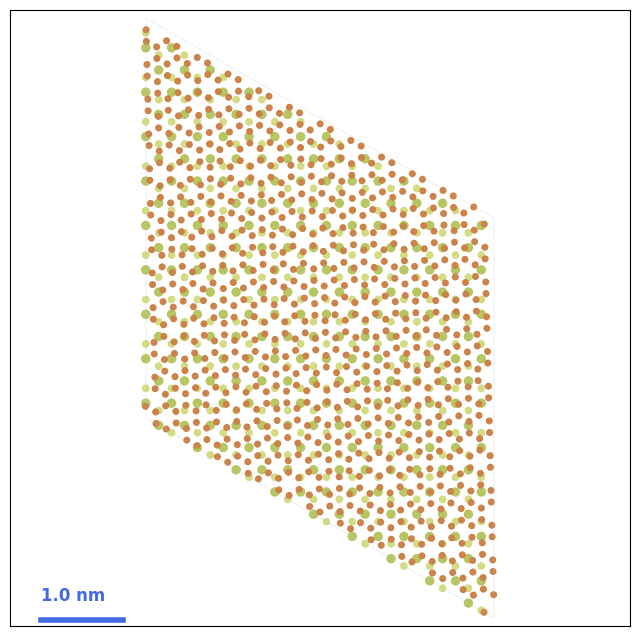

In [10]:
Smts[5][1].describeTM(Smts[5][1].MT)
Smts[5][0].primitive_lattice.showme(t=5)

Size of the primitive vectors: |a|=48.29432Å, |b|=48.29431Å
Angle between vectors: 120.000°
+-------------------------+---------------+-----------------------+-----------------------+--------+
|         Lattice         |       T       |      Deformation      |    Distortion:δ//θ    | #Atoms |
+-------------------------+---------------+-----------------------+-----------------------+--------+
|                         |  |  13    4|  |  | 1.00000  0.00000|  |    +0.0% // +0.0°     |  711   |
|           WS2           |  |  -4   17|  |  | 0.00000  1.00000|  |    +0.0% // +0.0°     |        |
|                         |               |                       |                       |        |
|                         |  |  16    6|  |  | 1.00213 -0.00000|  |   +0.213% // -0.0°    |  776   |
|        G(2.29°)         |  |  -6   22|  |  |-0.00000  1.00213|  |   +0.213% // +0.0°    |        |
|                         |               |                       |                       |        |

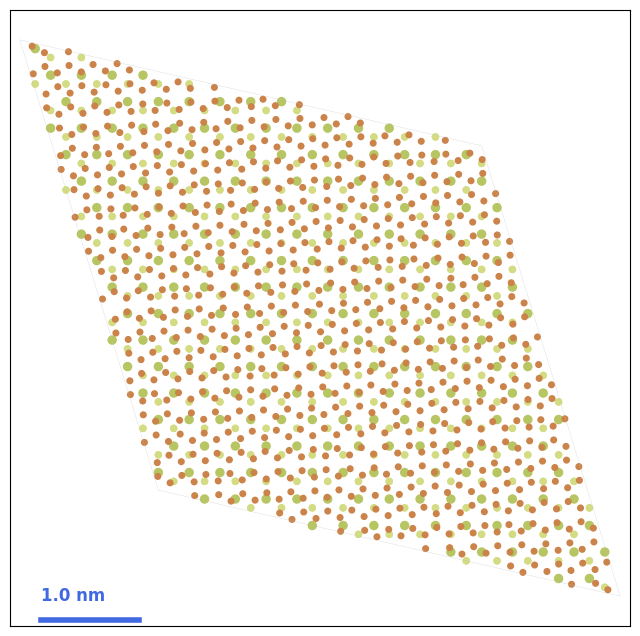

In [7]:
Smts[10][1].describeTM(Smts[10][1].MT)
Smts[10][0].primitive_lattice.showme(t=5)

Size of the primitive vectors: |a|=42.20473Å, |b|=42.20473Å
Angle between vectors: 120.000°
+-------------------------+---------------+-----------------------+-----------------------+--------+
|         Lattice         |       T       |      Deformation      |    Distortion:δ//θ    | #Atoms |
+-------------------------+---------------+-----------------------+-----------------------+--------+
|                         |  |   4   11|  |  | 1.00000  0.00000|  |    +0.0% // +0.0°     |  543   |
|           WS2           |  | -11   15|  |  | 0.00000  1.00000|  |    +0.0% // +0.0°     |        |
|                         |               |                       |                       |        |
|                         |  |   4   15|  |  | 0.99431 -0.00000|  |   -0.569% // +0.0°    |  602   |
|        G(3.40°)         |  | -15   19|  |  | 0.00000  0.99431|  |   -0.569% // +0.0°    |        |
|                         |               |                       |                       |        |

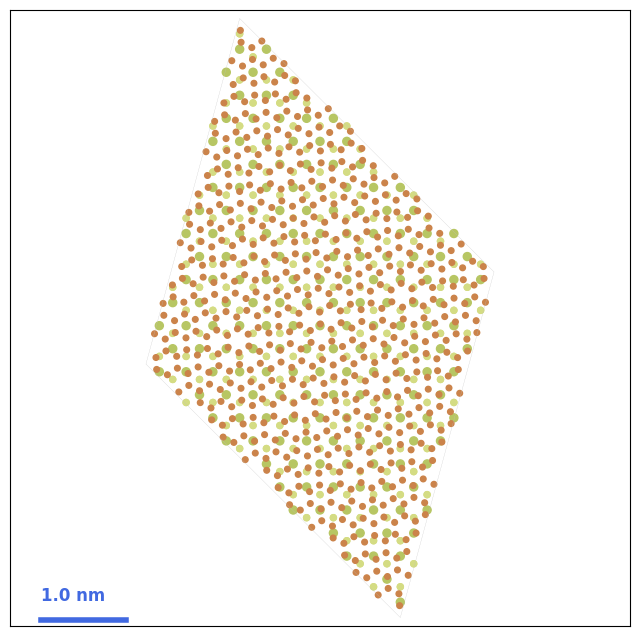

In [8]:
Smts[15][1].describeTM(Smts[15][1].MT)
Smts[15][0].primitive_lattice.showme(t=5)

Size of the primitive vectors: |a|=25.67789Å, |b|=25.67788Å
Angle between vectors: 120.000°
+-------------------------+---------------+-----------------------+-----------------------+--------+
|         Lattice         |       T       |      Deformation      |    Distortion:δ//θ    | #Atoms |
+-------------------------+---------------+-----------------------+-----------------------+--------+
|                         |  |   9   -2|  |  | 1.00000  0.00000|  |    +0.0% // +0.0°     |  201   |
|           WS2           |  |   2    7|  |  | 0.00000  1.00000|  |    +0.0% // +0.0°     |        |
|                         |               |                       |                       |        |
|                         |  |  11   -1|  |  | 0.99619 -0.00000|  |   -0.381% // +0.0°    |  222   |
|        G(7.50°)         |  |   1   10|  |  | 0.00000  0.99619|  |   -0.381% // +0.0°    |        |
|                         |               |                       |                       |        |

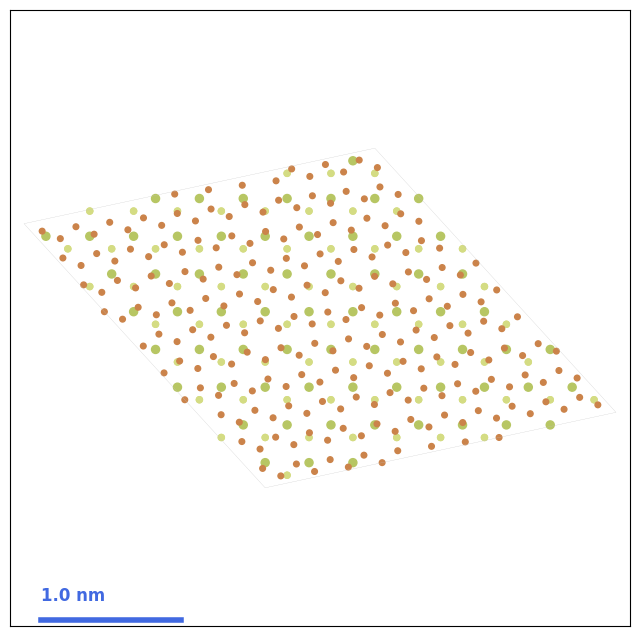

In [9]:
Smts[35][1].describeTM(Smts[35][1].MT)
Smts[35][0].primitive_lattice.showme(t=5)